O objetivo do exercício é praticar a codificação utilizando o Tensorflow e aplicar o mesmo nos conceitos apresentados em aula.

Neste exercício, utilizaremos um dataset bem conhecido: o dataset de dígitos escritos a mão do MNIST. Este dataset consiste em 60.000 imagens, de tamanho 28x28, dos dígitos de 0 a 9, escritos à mão. 

Devem ser criadas duas redes neurais capazes de classificar estas imagens: uma Rede Neural convencional (MLP), contendo duas camadas ocultas de 256 neurônios cada (ou qualquer valor que queira) e uma camada de saída. Algo semelhante à figura abaixo:

![Image](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

A segunda rede a ser codificada deve ser uma Rede Neural Convolucional (CNN) contendo ao menos duas camadas de convolução, duas camadas de pooling e uma camada fully-connected.

![Image](https://www.mdpi.com/entropy/entropy-19-00242/article_deploy/html/images/entropy-19-00242-g001.png)

Ao final da implementação de ambas, a acurácia das redes deve ser apresentada para verificação de qual rede se saiu melhor.

# Exercício
# Autor: Matheus Jericó Palhares
# Email: matheusjerico1994@hotmail.com
# linkedIn: https://www.linkedin.com/in/matheusjerico

In [1]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.ERROR)

#### Importando bibliotecas utilizadas

In [2]:
from keras.models import Sequential # Modelo
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization # Construção CNN e NN
from keras.layers import Conv2D, MaxPooling2D # Construção CNN
from keras.utils import np_utils # Utilizar to_categorical para categorização dos labels
from keras.datasets import mnist # Dataset
from matplotlib import pylab as plt # Gráfico
from keras import backend as K # Verificar o formato da imagem
from sklearn.metrics import classification_report, multilabel_confusion_matrix # metricas para validação
import numpy as np 
%matplotlib inline

Using TensorFlow backend.


#### Carregando o dataset a ser trabalhado

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Verificando formato das imagens
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_test.shape: {}".format(y_test.shape))

X_train.shape: (60000, 28, 28)
y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


## Pré-processamento dos dados

- Fazendo reshape:
    - Backend utilizando o tensor_flow: O formato da imagem é 'channels_last', coloca-se a profundidade da imagem no final;
    - Backend utilizando o Theano: O formato da imagem é 'channels_first', coloca-se a profundidade da imagem no início.
    
O código abaixo eu automatizo essa decisão, utilizando a função keras.backend.image_data_format(), a resposta da função é uma string: 'channels_first' para Theano como beckend e 'channels_last' para tensor_flow como beckend.

Já seto o parâmetro (input_shape) a ser passado na camada de entrada da MLP ou da CNN.

In [4]:
imagem_linhas = 28
imagem_colunas = 28

if K.image_data_format() == 'channels_first':
    print("image_data_format: channels_first")
    X_train = X_train.reshape(X_train.shape[0], 1, imagem_linhas, imagem_colunas)
    X_test = X_test.reshape(X_test.shape[0], 1, imagem_linhas, imagem_colunas)
    inputShape = (1, imagem_linhas, imagem_colunas)
else:
    print("image_data_format: channels_last")
    X_train = X_train.reshape(X_train.shape[0], imagem_linhas, imagem_colunas, 1)
    X_test = X_test.reshape(X_test.shape[0], imagem_linhas, imagem_colunas, 1)
    inputShape = (imagem_linhas, imagem_colunas, 1)

image_data_format: channels_last


- Após realizar o reshape da imagem adicionando a profundidade, verifico a modificação:

In [5]:
# Confirmando as dimensões dos X's
print('X_train.shape: {}'.format(X_train.shape))
print('X_test.shape: {}'.format(X_test.shape))

X_train.shape: (60000, 28, 28, 1)
X_test.shape: (10000, 28, 28, 1)


#### Pré-processamento das variáveis X's:
    - Transformo em array do tipo 'float' e divido por 255 para normalização os dados;
    - Os valores das matrizes das imagens que antes estavam entre 0 a 255, agora variam de 0 a 1.

In [6]:
# Transformando dados em float32 e normalizando (dados com valores de 0 até 1)
X_train = np.array(X_train, dtype='float32') / 255.
X_test = np.array(X_test, dtype='float32') / 255.

#### Pré-processamento das variáveis Y's:
    - Faço a verificação do formato dos labels, estão variando de 0 a 9 (apenas uma dimensão);
    - Faço a categorização para transformar os labels de uma dimensão para dez dimensões;

Exemplo:
    - O label do número '2' é o 2.
    - Após a categorização o label '2' vai passar a ser uma representação em formato de array com múltiplas dimensões:
    - [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    
    

In [7]:
# Verificando o formato dos labels
print("y_train.shape: {}".format(y_train.shape))

# Visualizando os 5 primeiros labels no y_train
print('Os 5 primeiros labels do y_train: {}'.format(y_train[:5]))

y_train.shape: (60000,)
Os 5 primeiros labels do y_train: [5 0 4 1 9]


- Faço a categorização dos labels:

In [8]:
# Categorizando dos Y's
# Converter o array que possui apenas 1 dimensão, em um array com 10 dimensões.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [9]:
# Verificando as dimensões do array
print('y_train.shape: {}'.format(y_train.shape))
print('y_test.shape: {}'.format(y_test.shape))

y_train.shape: (60000, 10)
y_test.shape: (10000, 10)


## Criando modelo com MLP

- Flatten(): Tranformar a imagem que está em formato de matriz para o formato de vetor;
- Dense(): Camada densa da Rede neural, a primeira camada Dense tem que ter o parâmetro de input_shape com a dimensão da imagem e profundidade. A quantidade de nodes para a primeira camada foi 28 x 28 (tamanho da imagem);
- Activation(): Função de ativação, optei por utilizar a ReLu pois tenho um bom resultado com ela;
- BatchNormalization(): Utilizado para normalizar as ativações da camada anterior, obtive uma melhora na acurácia e uma menor probabilidade de ocorrer overfitting;
- Dropout(): Aplicado para prevenir overfitting durante o treinamento, 'cancela' 20% (parâmetro selecionado) das ligações entre nodes.

Reduzi o número de nodes pela metade em cada camada Densa, até que na camada de saída tenho 10 nodes, pois temos 10 classes a serem classificadas.

Função utilizada foi o 'softmax', apresenta a probabilidade de classificação de cada classe, fazendo a selecão da classe que tem maior probabilidade.


In [10]:
# Iniciando modelo MLP
model_mlp = Sequential()

# Flatten()
model_mlp.add(Flatten())

# Camada de entrada:
model_mlp.add(Dense(784, input_shape = (28, 28, 1))) 
model_mlp.add(Activation("relu")) 
model_mlp.add(BatchNormalization()) 
model_mlp.add(Dropout(0.2)) 

# 1º camada oculta:
model_mlp.add(Dense(392))
model_mlp.add(Activation("relu"))
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2))

# 2º camada oculta:
model_mlp.add(Dense(196))
model_mlp.add(Activation("relu"))
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.2))

# Camada de saida:
model_mlp.add(Dense(10))
model_mlp.add(Activation("softmax"))

### Compilando o Modelo
- loss: 'categorical_crossentropy' utilizado pois é uma classificação com mais de 2 classes;
- optimizer: 'adam' foi escolhido pois obtive um melhor resultado do que usando o 'sgd'. Backpropagation.

In [11]:
# Compilando modelo MLP:
model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Treinando o modelo
- Passo os dados de treino, tamanho do lote, épocas e os dados de validação.

In [12]:
# Parâmetros:
BS = 128
EPOCHS = 10

# Fit no modelo
H1 = model_mlp.fit(X_train, y_train, batch_size=BS, epochs= EPOCHS, verbose=1, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s 390us/step - loss: 0.2288 - acc: 0.9297 - val_loss: 0.1141 - val_acc: 0.9633
Epoch 2/10
60000/60000 [==============================] - 20s 333us/step - loss: 0.1026 - acc: 0.9677 - val_loss: 0.0882 - val_acc: 0.9724
Epoch 3/10
60000/60000 [==============================] - 20s 330us/step - loss: 0.0812 - acc: 0.9738 - val_loss: 0.0774 - val_acc: 0.9772
Epoch 4/10
60000/60000 [==============================] - 20s 327us/step - loss: 0.0665 - acc: 0.9793 - val_loss: 0.0785 - val_acc: 0.9751
Epoch 5/10
60000/60000 [==============================] - 20s 328us/step - loss: 0.0592 - acc: 0.9811 - val_loss: 0.0713 - val_acc: 0.9792
Epoch 6/10
60000/60000 [==============================] - 19s 325us/step - loss: 0.0509 - acc: 0.9830 - val_loss: 0.0687 - val_acc: 0.9801
Epoch 7/10
60000/60000 [==============================] - 19s 325us/step - loss: 0.0466 - acc: 0.9847 - val_loss: 0.

### Avaliando modelo MLP
- Utilizo a função evaluate() para obter a acurácia e o erro nos dados de teste

In [13]:
# Mostrando resultados do modelo MLP
scores_mlp = model_mlp.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 193us/step


In [14]:
# Mostrando o erro e acurácia do modelo MLP
print("Loss do Modelo MLP: {}%".format(scores_mlp[0]*100))
print("Accuracy do Modelo MLP: {}%".format(scores_mlp[1]*100))

Loss do Modelo MLP: 6.15795305685082%
Accuracy do Modelo MLP: 98.32%


#### Predição do modelo MLP
- Utilizo a função predict_classes() para fazer a predição dos dados de teste.
- Categorizo a predição.

In [15]:
# Fazendo predição do modelo MLP
preds_mlp = model_mlp.predict_classes(X_test)
print(preds_mlp[1])
preds_mlp = np_utils.to_categorical(preds_mlp)
print(preds_mlp[1])

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


- Avaliando o modelo com a função classification_report(): obtenho as metricas de precisão, recall e f1-score, além da quantidade de imagens para cada classificação

In [16]:
# Mostrando precisão, recall e f1-score do modelo MLP
print(classification_report(y_test, preds_mlp))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000
 samples avg       0.98      0.98      0.98     10000



- Utilizo a função multilabel_confusion_matrix() para verificar a matriz de confusão de cada label

In [17]:
# Matriz de confusão do Modelo MLP
 matriz_confusão = multilabel_confusion_matrix(y_test, preds_mlp)

In [18]:
# Visualizando matriz de confusão do Modelo MLP
for i, matriz in enumerate(matriz_confusão):
    print("\nMatriz de confusão do classificação do número: {}".format(i))
    print(matriz)


Matriz de confusão do classificação do número: 0
[[9008   12]
 [  11  969]]

Matriz de confusão do classificação do número: 1
[[8854   11]
 [   9 1126]]

Matriz de confusão do classificação do número: 2
[[8946   22]
 [  14 1018]]

Matriz de confusão do classificação do número: 3
[[8976   14]
 [  20  990]]

Matriz de confusão do classificação do número: 4
[[8997   21]
 [  17  965]]

Matriz de confusão do classificação do número: 5
[[9100    8]
 [  18  874]]

Matriz de confusão do classificação do número: 6
[[9031   11]
 [  17  941]]

Matriz de confusão do classificação do número: 7
[[8950   22]
 [  22 1006]]

Matriz de confusão do classificação do número: 8
[[9006   20]
 [  24  950]]

Matriz de confusão do classificação do número: 9
[[8964   27]
 [  16  993]]


### Gráfico de rendimento do Modelo MLP de acordo com as Épocas

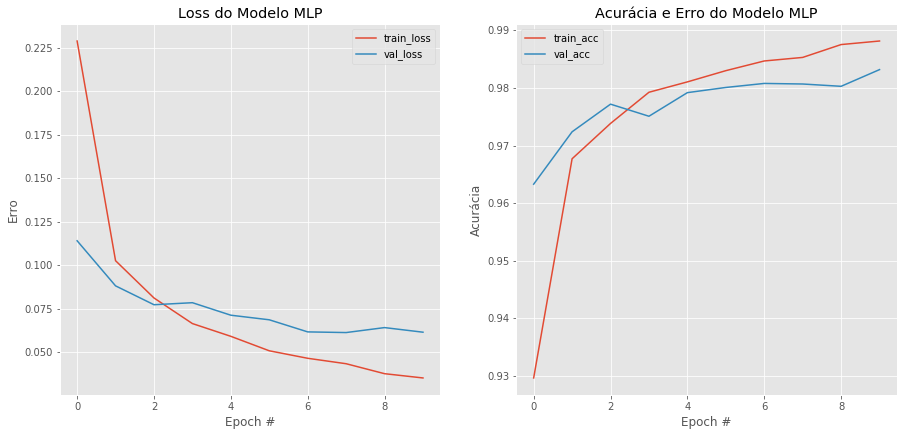

In [19]:
# Plotando gráfico de rendimento do Modelo MLP
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.title("Loss do Modelo MLP")
plt.plot(np.arange(0, N), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H1.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Erro")
plt.legend()

plt.subplot(222)
plt.title("Acurácia e Erro do Modelo MLP")
plt.plot(np.arange(0, N), H1.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H1.history["val_acc"], label="val_acc")
plt.title("Acurácia e Erro do Modelo MLP")
plt.xlabel("Epoch #")
plt.ylabel("Acurácia")
plt.legend()

## Criando modelo CNN

- Conv2D(): Camada de convolução espacial sobre imagens:

    - Parâmetros:

        - filters: Números de filtros de saída da convolução;
        - kernel_size: Altura e largura do filtro de convolução;
        - activation: Função de ativação;
        - padding: 'same' => Preenche o redor da imagem com valores zeros para aplicar o filtro com maior precisão;
        - input_shape: Utilizado na camada de entrada, informando o formato da imagem.

- BatchNormalization(): Utilizado para normalizar as ativações da camada anterior, obtive uma melhora na acurácia e uma menor probabilidade de ocorrer overfitting;

- MaxPooling2D: Aplica o maxpooling com janela de tamanho 2x2;

- Dropout(): Aplicado para prevenir overfitting durante o treinamento, 'cancela' 20% (parâmetro selecionado) das ligações entre nodes;

- Flatten(): Tranformar a imagem que está em formato de matriz para o formato de vetor;

- Dense(): Camada densa da Rede neural, a primeira camada Dense tem que ter o parâmetro de input_shape com a dimensão da imagem e profundidade. A quantidade de nodes para a primeira camada foi 28 x 28 (tamanho da imagem);

- Activation(): Função de ativação, optei por utilizar a ReLu pois tenho um bom resultado com ela.


Reduzi o número de nodes pela metade em cada camada Densa, até que na camada de saída tenho 10 nodes, pois temos 10 classes a serem classificadas.

Função utilizada foi o 'softmax', apresenta a probabilidade de classificação de cada classe, fazendo a selecão da classe que tem maior probabilidade.

Na CNN estou utilizando a função de ativação como parâmetro dentro da Convolução e da Densa.


In [20]:
# Iniciando modelo CNN
model_cnn = Sequential()

# Camada de entrada Convolução:
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation = 'relu', padding='same', input_shape=inputShape))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size = (2,2))) 
model_cnn.add(Dropout(0.25))

# 2º camada de convolução:
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu', padding='same')) 
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size = (2,2)))
model_cnn.add(Dropout(0.25))

# Flatten():
model_cnn.add(Flatten())

# 1º camada Densa:
model_cnn.add(Dense(128, activation = 'relu'))
model_mlp.add(BatchNormalization())
model_cnn.add(Dropout(0.25))

# 2º camada Densa:
model_cnn.add(Dense(64, activation = 'relu'))
model_mlp.add(BatchNormalization())
model_cnn.add(Dropout(0.25))

# Camada de saída:
model_cnn.add(Dense(10, activation = 'softmax')) # camada de saída: 10 pq são 10 classes de saída
                                                 # softmax: escolhe o número com maior probabilidade

### Compilando o Modelo
- loss: 'categorical_crossentropy' utilizado pois é uma classificação com mais de 2 classes;
- optimizer: 'adam' foi escolhido pois obtive um melhor resultado do que usando o 'sgd'. Backpropagation.

In [21]:
# Compilar o modelo de CNN
model_cnn.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

### Treinando o modelo
- Passo os dados de treino, tamanho do lote, épocas e os dados de validação.
- Mesmos parâmetros utilizados no treinamento do modelo MLP.

In [22]:
# Fit no modelo de CNN
H2 = model_cnn.fit(X_train, y_train, batch_size=BS, epochs= EPOCHS, verbose=1, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 134s 2ms/step - loss: 0.3863 - acc: 0.8843 - val_loss: 0.0593 - val_acc: 0.9816
Epoch 2/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1288 - acc: 0.9656 - val_loss: 0.0521 - val_acc: 0.9841
Epoch 3/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0954 - acc: 0.9733 - val_loss: 0.0344 - val_acc: 0.9879
Epoch 4/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0752 - acc: 0.9788 - val_loss: 0.0316 - val_acc: 0.9905
Epoch 5/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0651 - acc: 0.9814 - val_loss: 0.0318 - val_acc: 0.9895
Epoch 6/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0600 - acc: 0.9839 - val_loss: 0.0305 - val_acc: 0.9905
Epoch 7/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0563 - acc: 0.9836 - val_loss: 0.0373 - 

### Avaliando modelo CNN
- Utilizo a função evaluate() para obter a acurácia e o erro nos dados de teste.

In [23]:
# Mostrando resultados do Modelo CNN
scores_cnn = model_cnn.evaluate(X_test, y_test)

10000/10000 [==============================] - 12s 1ms/step


In [24]:
# Printando Erro e Acurácia do Modelo CNN
print("Loss: {}".format(scores_cnn[0]))
print("Accuracy: {}".format(scores_cnn[1]))

Loss: 0.028085845008607294
Accuracy: 0.9917


#### Predição do modelo CNN
- Utilizo a função predict_classes() para fazer a predição dos dados de teste.
- Categorizo a predição.

In [25]:
# Fazendo predição do Modelo CNN
preds_cnn = model_cnn.predict_classes(X_test)
print(preds_cnn[1])
preds_cnn = np_utils.to_categorical(preds_cnn)
print(preds_cnn[1])

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


- Avaliando o modelo com a função classification_report(): obtenho as metricas de precisão, recall e f1-score, além da quantidade de imagens para cada classificação

In [26]:
# Mostrando os valores de precisão, recall, f1-score do modelo CNN
print(classification_report(y_test, preds_cnn))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.98      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.98      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000
 samples avg       0.99      0.99      0.99     10000



- Utilizo a função multilabel_confusion_matrix() para verificar a matriz de confusão de cada label

In [27]:
# Matriz de confusão do Modelo cnn
matriz_confusão = multilabel_confusion_matrix(y_test, preds_cnn)

In [28]:
# Visualizando matriz de confusão do Modelo CNN
for i, matriz in enumerate(matriz_confusão):
    print("\nMatriz de confusão do classificação do número: {}".format(i))
    print(matriz)


Matriz de confusão do classificação do número: 0
[[9009   11]
 [   2  978]]

Matriz de confusão do classificação do número: 1
[[8862    3]
 [   6 1129]]

Matriz de confusão do classificação do número: 2
[[8950   18]
 [   2 1030]]

Matriz de confusão do classificação do número: 3
[[8974   16]
 [   2 1008]]

Matriz de confusão do classificação do número: 4
[[9016    2]
 [   9  973]]

Matriz de confusão do classificação do número: 5
[[9098   10]
 [  14  878]]

Matriz de confusão do classificação do número: 6
[[9038    4]
 [  15  943]]

Matriz de confusão do classificação do número: 7
[[8969    3]
 [  15 1013]]

Matriz de confusão do classificação do número: 8
[[9020    6]
 [   7  967]]

Matriz de confusão do classificação do número: 9
[[8981   10]
 [  11  998]]


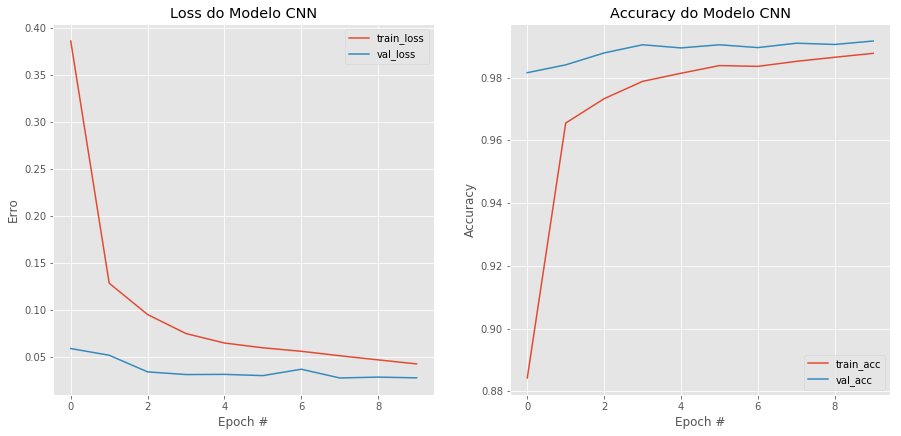

In [29]:
# Plotando gráfico de rendimento do Modelo MLP
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.title("Loss do Modelo CNN")
plt.plot(np.arange(0, N), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H2.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Erro")
plt.legend()

plt.subplot(222)
plt.title("Accuracy do Modelo CNN")
plt.plot(np.arange(0, N), H2.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H2.history["val_acc"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

## Comparação do Loss e Accuracy dos modelos MLP e CNN

In [30]:
print('Accuracy:\nModelo MLP: {} %\nModelo CNN: {} %\n'.format((scores_mlp[1]*100), (scores_cnn[1])*100))
print('Loss:\nModelo MLP: {:.5} %\nModelo CNN: {:.5} %'.format((scores_mlp[0]*100), (scores_cnn[0])*100))

Accuracy:
Modelo MLP: 98.32 %
Modelo CNN: 99.17 %

Loss:
Modelo MLP: 6.158 %
Modelo CNN: 2.8086 %


# Resultado
- O modelo CNN obteve uma maior porcentagem de Acurácia e uma menor porcentagem de Erro;
- Nota-se claramente que utilizando as camadas de convolução para extrair as principais características da imagem antes das camadas densas da Rede Neural, o modelo tem um melhor resultado.